In [115]:
%matplotlib inline
import importlib as imp
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style('ticks');
current_colors = sns.color_palette()
sns.set_palette('Accent');

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True

import Calculate_ABA_Finkelsteinlab_Diewertje as CalcABA
imp.reload(CalcABA);
import plotting_ABA_Diewertje_deltaABA as pltABA
imp.reload(pltABA);
import plotting_Boyle_Diewertje as plt_B
imp.reload(plt_B);

import sys 
sys.path.append('../code_general/')
import CRISPR_free_energy_landscape_Diewertje as FreeEnergy
imp.reload(FreeEnergy);
import read_model_ID;
imp.reload(read_model_ID);

import sys 
sys.path.append('../code_general_Finkelsteinlab/')
import plotting_Finkelsteinlab as plt_F
imp.reload(plt_F)


import analysis_SA_fits_Diewertje as SAfits
imp.reload(SAfits);



In [116]:
simset3 = []
no_good = []
# Used concentrations: [10,100]
chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,11):
    sa = pd.read_csv('../Diewertje/24_5_2019_cas12_conc3/fit_24_5_2019_cas12_conc3_sim_' +str(sim)+'.txt', delimiter='\t', index_col=45)
    filename = '../Diewertje/24_5_2019_cas12_conc3/fit_24_5_2019_cas12_conc3_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    simset3.append(filename)
        
    
best_fit_conc3 = simset3[np.argmin(chi_squared)]
sim5='../Diewertje/24_5_2019_cas12_conc3/fit_24_5_2019_cas12_conc3_sim_5.txt'
sim7='../Diewertje/24_5_2019_cas12_conc3/fit_24_5_2019_cas12_conc3_sim_7.txt'

best_fit_conc3

'../Diewertje/24_5_2019_cas12_conc3/fit_24_5_2019_cas12_conc3_sim_1.txt'

In [117]:
print('The chi-squared of the best fit is:',chi_squared[4])

The chi-squared of the best fit is: 49181.9900231


In [118]:
chi_squared

[48182.42562930001,
 65367.7226638,
 52462.2161307,
 62642.789747300005,
 49181.9900231,
 50130.4589056,
 53263.8020015,
 50860.178918900005,
 172502.458514,
 48575.4364864]

In [119]:
# Load data
import Prepare_data as Pre
rawABA=pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas12a-target-d-replicate-1-delta-abas_Canonical_OT-r_0-2.csv')
rawABA

cas9=pd.read_csv('../Data_ABA_Finkelsteinlab/cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-2.csv')
x,_,_=Pre.Prepare_Cdata('../Data_ABA_Finkelsteinlab/','cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-2.csv')

# prepare data
path_to_data= '../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'
filename= 'cas12a-target-d-replicate-1-delta-abas_Canonical_OT-r_0-2.csv'
xdata,ydata,yerr=Pre.Prepare_Cdata(path_to_data,filename) 


In [120]:
# Load Parameters to calculate the chi-squared for best fit
import get_parameters_fit_Diewertje as getParm
Nparams=44
concentrations=np.array([1,30,100])
Param_conc3=getParm.load_simm_anneal(best_fit_conc3,Nparams)

In [121]:
Param5=getParm.load_simm_anneal(sim5,Nparams)
Param7=getParm.load_simm_anneal(sim7,Nparams)

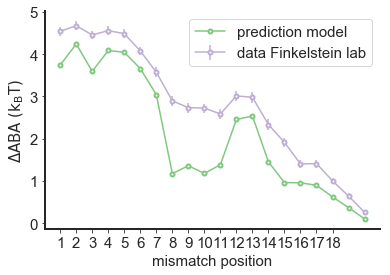

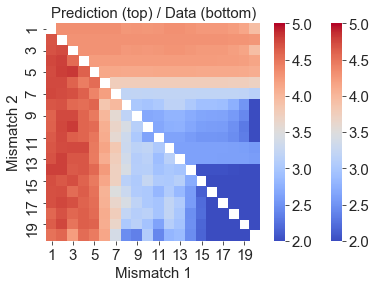

In [122]:
import plotting_simple_fit as pltS
T=60*10
guide_length=20
model_id = 'general_energies_no_kPR'

plt.figure()
_ = pltABA.predict_single_mm(Param_conc3,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)


plt.figure()
best_heatmap = pltABA.predict_double_mm_delta(Param_conc3,model_id,T, guide_length, show_plot=True, show_data=True, data_file=rawABA)

# Cannot do those plots, because do not have block data
# plt.figure()
# _ = pltABA.predict_1D_mmblocks(Param_normal, model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
# plt.figure()
# _ = pltABA.predict_block_mismatches(Param_normal, model_id, T,guide_length, show_plot=True, show_data=True, data_file=rawABA)



# Now selection based on agreement with data

In [7]:
def select_on_prediction_WA(simset,
                            percentage=0.1,
                            Nparams=43,
                            model_id='general_energies_no_kPR',
                            path='../Data_Boyle/',
                            replica='1'):
    # in my case replica is filename!
    scores = []
    for sim in simset:
        #print sim
        parameters = getParm.load_simm_anneal(sim, Nparams)
        score, _, _ = predict_train(parameters, model_id=model_id, path=path, replica=replica, Plot=False)
        scores.append(score)
    scores = np.array(scores)
    simset = np.array(simset)
    selected_scores = scores[scores <= percentage]
    selected_sims = simset[scores <= percentage]
    return selected_sims, selected_scores, scores


import os
import numpy as np
import pandas as pd
import Boyle_data_processing as process
import CRISPR_dCas9_binding_curve_Boyle as dCas9
import matplotlib.pylab as plt
import Prepare_data as prep

import Calculate_ABA_Finkelsteinlab_Diewertje as ABA


# BASED ON ABA AVARAGE DATA AND PREDICTED ABA

def Weighted_average(row):
    y = np.array(row['ydata'])
    e = np.array(row['yerr'])
    wa=np.average(y, weights=e ** -2, axis=0)
    return wa


def calc_Weighted_average(path='../Data_Boyle/', replica='1', outputdirectory='../Data_Boyle/Weighted_Avarage/',
                          save=True):
    # For me replica is the filename
    xdata, ydata, yerr = prep.Prepare_Cdata(path=path,filename=replica)
    data = pd.DataFrame(columns=['xdata', 'ydata', 'yerr'])
    data['xdata'] = xdata
    data['ydata'] = ydata
    data['yerr'] = yerr
    wa = []
    for i in data.index:
        wa.append(Weighted_average(data.loc[i]))
    #data['WA'] = wa
    #data['WA'] = data.apply(Weighted_average, axis=1)

    WA = pd.DataFrame(columns=['MM_pos', 'WA_data'])
    WA.MM_pos = xdata
    WA.WA_data = wa
    return WA


def predict_train(parameters, model_id='general_energies_no_kPR', path='../Data_Boyle/', replica='1', Plot=True):
    wa = calc_Weighted_average(path=path, replica=replica, save=False)
    prediction=wa.copy()
    concentrations=np.array([0.1,0.3,1.,3.,10.,30.,100.,300.])
    reference=1
    prediction['WA_model']=wa['MM_pos'].apply(lambda x: ABA.calc_ABA(parameters,concentrations,reference,x.tolist(),model_id,guide_length=20,T=10*60))
    score = prediction.dropna().apply(lambda x: np.abs(x['WA_data'] - x['WA_model']) / x['WA_data'], axis=1).mean()
    corr=0
    return score, corr, prediction


In [77]:
# select based on dataset instead of best fit:
selected_sims, selected_scores, scores = select_on_prediction_WA(simset3,
                                                                        percentage=0.036,
                                                                        model_id='general_energies_no_kPR',
                                                                        path=path_to_data,
                                                                        replica='cas12a-target-d-replicate-1-delta-abas_Canonical_OT-r_0-2.csv')
# replica is filename of the data in my case!

C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\Diewertje\Python\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


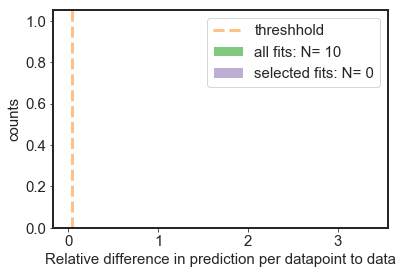

In [78]:
plt.hist(scores, normed=False, bins=np.arange(0,max(scores),0.001), label='all fits: N= ' +str(len(scores)))
plt.hist(selected_scores,normed=False, bins=np.arange(0,max(scores),0.001), label='selected fits: N= ' +str(len(selected_scores)));

plt.axvline(0.036, linestyle='dashed', linewidth=3, color=sns.color_palette()[2], label='threshhold')


plt.legend(fontsize=15);
plt.xlabel('Relative difference in prediction per datapoint to data', fontsize=15);
plt.ylabel('counts', fontsize=15);
plt.xticks(fontsize=15);

plt.yticks(fontsize=15);

In [79]:
scores

array([0.48835518, 1.39258973, 0.74196403, 0.80598105, 0.32829253,
       0.2881441 , 0.04556594, 0.25994012, 3.38774722, 1.60845444])

# Plot of weighted average

In [12]:
percentage=0.1,
model_id='general_energies_no_kPR'
path=path_to_data
replica='cas12a-target-d-replicate-1-delta-abas_Canonical_OT-r_0-2.csv'


WA=calc_Weighted_average(path,replica,save=False)
WA['WA_data_delta']=WA['WA_data']#-2.5545002878227865 
# substract ontarget to go to delta ABA


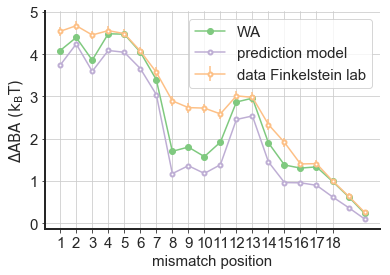

In [90]:
WAsingle=[]
singlePos=[]
for i in range(len(WA)):
    if (len(WA['MM_pos'][i])==1):
        singlePos.append(WA['MM_pos'][i])
        WAsingle.append(WA['WA_data_delta'][i])

WAsingle_ordered=np.empty(len(WAsingle)+1)
for i in range(1,len(WAsingle)+1):
    WAsingle_ordered[singlePos[i-1]]=WAsingle[i-1]
len(WAsingle_ordered)
plt.figure()
plt.plot(range(1,21),WAsingle_ordered[1:],marker='o',label='WA')
delta1 = pltABA.predict_single_mm(Param_conc3,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
plt.legend()
plt.grid()

In [126]:
concentrations = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300]) #2 ** np.array(range(0, 11)) * 0.5
reference_conc = 1 #10

ontarget_ABA = CalcABA.calc_ABA(Param_conc3, concentrations, reference=1,
                                    mismatch_positions=[],
                                    model_id=model_id,
                                    guide_length=20,
                                    T=60 * 10)
ontarget_ABA


-1.0116464605386954

Text(0.5, 1.0, 'Prediction (top) / WA (bottom)')

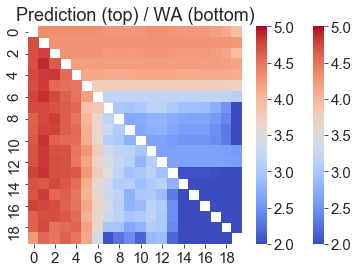

In [128]:
#-----For double mismatches-----
WAdouble=[]
doublePos=[]
for i in range(len(WA)):
    if (len(WA['MM_pos'][i])==2):
        doublePos.append(WA['MM_pos'][i])
        WAdouble.append(WA['WA_data'][i])
mapABA=np.zeros([20,20])
mapABA[:]=np.nan
for i in range(len(doublePos)):
    mapABA[doublePos[i][0]-1,doublePos[i][1]-1]=WAdouble[i]

import seaborn as sns
plt.figure()
best_heatmap = pltABA.predict_double_mm(Param_conc3,model_id,T, guide_length, show_plot=True, show_data=False, data_file=rawABA)

sns.heatmap(mapABA.transpose(), cmap='coolwarm', cbar=True, vmin=2,vmax=5)
plt.title('Prediction (top) / WA (bottom)')

In [24]:
# --- make selection --- 
#simset3 = selected_sims 

# --- store resulting fit parameters in a set of Dataframes --- 
matches, mismatches, rates, landscape, free_energy, fast_Rloop = SAfits.process_SA_fits(simset3,44,'general_energies_no_kPR')
forward_rates = rates[['sol_to_PAM','PAM_to_R1','internal']]
matches.loc[best_fit_conc3]

PAM    3.500000
1     -3.778753
2     -2.835476
3      3.992028
4      0.466997
5      1.546399
6      0.863381
7     -5.811053
8      6.012401
9     -2.662546
10     1.802792
11    -2.624408
12    -0.112161
13     4.539935
14     1.669655
15    -8.831084
16     3.652969
17     5.033336
18     0.625007
19     1.323008
20     1.315787
Name: ../Diewertje/24_5_2019_cas12_conc3/fit_24_5_2019_cas12_conc3_sim_1.txt, dtype: float64

C:\Users\Diewertje\Python\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


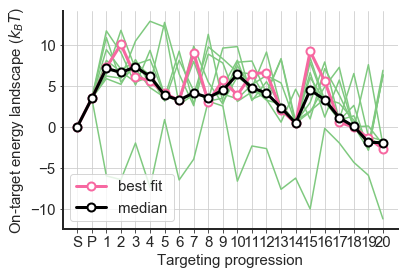

In [25]:
# --- (microscopic) free-energy landscape --- 
plt.figure()
Nparams=41
for filename in simset3:
    parameters = plt_B.load_simm_anneal(filename, Nparams)
    parameters[0]=3.5 # if want to fix epsilon PAM
    Energy_landscape, FreeEnergy_landscape = FreeEnergy.plot_free_energy_landscape(parameters,model_id='fixed_rates',show_plot=False);
    #plt.figure()
    plt.plot(np.array(Energy_landscape),color=sns.color_palette()[0])
lowest_chi_squared = np.array( landscape.loc[best_fit_conc3] )


plt.plot(np.array(lowest_chi_squared), color='#f768a1' , 
         marker='o', 
         lw=3,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='best fit');

LandscapeMED = landscape[landscape.columns[:]].median()
plt.plot(np.array(LandscapeMED),color='black' , 
         marker='o',
         lw=3,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='median');

plt.legend(fontsize=15,frameon=True)
plt.xlim(-1,22)
plt.xticks(list(range(0,22)),['S','P']+list(LandscapeMED.index[2:]),  fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Targeting progression',fontsize=15)
plt.ylabel('On-target energy landscape ($k_BT$)',fontsize=15)
plt.grid('on')
sns.despine();


In [132]:
-np.log(np.sum(np.exp(landscape.loc[best_fit_conc3])))


-10.783382499897204

In [133]:
np.exp(ontarget_ABA)

0.36361980079167927

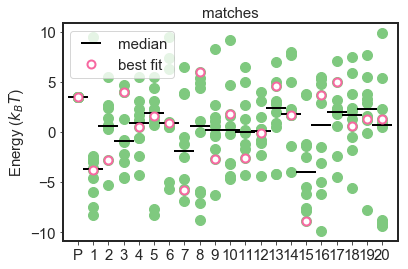

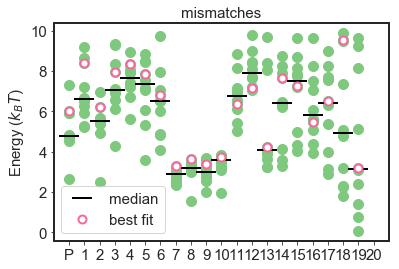

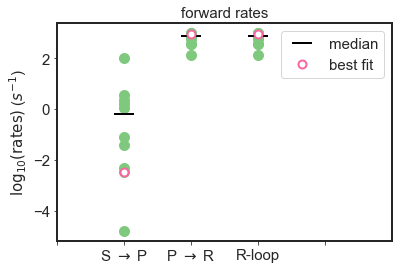

In [134]:
# ---- show fluctuations in parameter sets --- 
# THIS IS THE RESULT

# --- Matches ---
# MAYBE WE WANT TO NEGATE (multiply by -1 all the epsilonC to have the same sign convention as EpsilonPAM and EpsilonI)
plt.figure()
for sim in simset3:
    matches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

matches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    

matches.loc[best_fit_conc3].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('matches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);

# --- Mismatches --- 
plt.figure()
for sim in simset3:
    mismatches.loc[sim].plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

mismatches.median().plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    

mismatches.loc[best_fit_conc3].plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('mismatches',fontsize=15)
plt.xticks(list(range(0,21)),['P']+list(range(1,21)),fontsize=15);
plt.xlim(-1,21);
plt.yticks(fontsize=15);
plt.ylabel('Energy ($k_BT$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);


# --- 10log of the forward rates --- 
plt.figure()
for sim in simset3:
    forward_rates.loc[sim].apply(np.log10).plot(marker='o',markersize=10,linestyle='', color=sns.color_palette()[0], alpha=1.0,label='')

forward_rates.median().apply(np.log10).plot(color='black',
            linestyle='',
             marker='_', 
             lw=4,
             markersize =20,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='median')    
    
    

forward_rates.loc[best_fit_conc3].apply(np.log10).plot(color='#f768a1',
            linestyle='',
             marker='o', 
             lw=3,
             markersize =8,
             markerfacecolor='white',
             markeredgewidth= 2,
        label='best fit')



plt.title('forward rates',fontsize=15)
plt.xticks(range(-1,4),['',r'S $\rightarrow$ P',r'P $\rightarrow$ R','R-loop',''],fontsize=15);
plt.xlim(-1,4);
plt.yticks(fontsize=15);
plt.ylabel(r'$\log_{10}(\rm{rates})$ ($s^{-1}$)',fontsize=15);
plt.legend(fontsize=15,frameon=True);




In [135]:
forward_rates['PAM_to_R1'].mean()

689.9929721393307

In [136]:
forward_rates.loc[best_fit_conc3]

sol_to_PAM      0.003316
PAM_to_R1     950.518948
internal      950.518948
Name: ../Diewertje/24_5_2019_cas12_conc3/fit_24_5_2019_cas12_conc3_sim_1.txt, dtype: float64

In [111]:
def plot_single_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True, Plot=True):

    Mut_names = {'r':'Mismatch', 'i':'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]
    
    data['Mutation Type'].fillna('', inplace=True)
    single_mut_data = data[(data['Canonical']==Canonical)&(data['Mutation Type']==Mut_type)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    single_mut_data['Position'] = single_mut_data['Mutation ID'].apply(lambda x: int(x.split(':')[1]))
    single_mut_data_mean = single_mut_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()
    
    if Plot:
        single_mut_data_mean.plot(x='Position', y='Delta ABA (kBT)',yerr='Uncertainty', marker='o', linewidth=1, color='blue') 
        plt.xlabel(Mut_name+' postion', fontsize=15)
        plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
        if not Canonical:
            plt.title(data_name + ' - Noncanonical',fontsize=15)
    
    return single_mut_data_mean

def plot_double_mut_ABA(data, Mut_type, data_name='Finkelstein Data', Canonical=True, Plot=True):
    
    Mut_names = {'r':'Mismatch', 'i':'Insertion', 'd': 'Deletion'}
    Mut_name = Mut_names[Mut_type]
    Mut_type_str = Mut_type+'|'+Mut_type
    
    data['Mutation Type'].fillna('', inplace=True)
    double_mut_data = data[(data['Canonical']==Canonical)&(data['Mutation Type']==Mut_type_str)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    double_mut_data['Position'] = double_mut_data['Mutation ID'].apply(lambda x: '|'.join(map(lambda y: y.split(':')[1], x.split('|'))))
    double_mut_data_mean = double_mut_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()

    Ng = 20;
    double_mut_map = np.empty((Ng,Ng))
    double_mut_map[:] = np.nan
    for n in range(len(double_mut_data_mean)):
        pos = double_mut_data_mean['Position'].iloc[n]
        Positions = list(map(lambda x: int(x)-1, pos.split('|')))
        double_mut_map[Positions[1],Positions[0]] = double_mut_data_mean['Delta ABA (kBT)'].iloc[n]
        
    if Plot:    
        plt.figure()
        sns.heatmap(double_mut_map, cmap='coolwarm',cbar=True,vmin=0,vmax=double_mut_data_mean['Delta ABA (kBT)'].max())
        plt.xlabel(Mut_name+' 1', fontsize=15)
        plt.ylabel(Mut_name+' 2', fontsize=15)
        plt.title('$\Delta$ABA - '+data_name,fontsize=15)
        if not Canonical:
            plt.title('$\Delta$ABA - '+data_name+' - Noncanonical',fontsize=15)
        ax = plt.gca()
        ax.set_xticklabels(list(map(lambda x: str(int(x)),ax.get_xticks()+0.5)));
        ax.set_yticklabels(list(map(lambda x: str(int(x)),ax.get_yticks()+0.5)));
    
    return double_mut_data_mean, double_mut_map

def make_block_ID(MM_pos_list):
    
    bi = MM_pos_list[0]
    bf = MM_pos_list[-1]
    block = np.arange(bi,bf+1)
    if (len(block)!=len(MM_pos_list)) or np.any(block!=np.array(MM_pos_list)):
        return ''
    return '|'.join(list(map(str, [bi, bf])))

def plot_block_mm_ABA(data, data_name='Finkelstein Data', Canonical=True, Plot=True):
    
    data['Mutation Type'].fillna('', inplace=True)
    select_multi_mm = data['Mutation Type'].apply(lambda x: np.unique(np.array(x.split('|')))[0]=='r')
    multi_mm_data = data[(data['Canonical']==Canonical)&(select_multi_mm)&(data['Mutation Count']>2)][['Mutation ID', 'Delta ABA (kBT)', 'Uncertainty']]
    multi_mm_data['MM Positions'] = multi_mm_data['Mutation ID'].apply(lambda x: list(map(lambda y: int(y.split(':')[1]), x.split('|'))))
    multi_mm_data['Position'] = multi_mm_data['MM Positions'].apply(make_block_ID)
    multi_mm_data = multi_mm_data[(multi_mm_data['Position']!='')]
    block_mm_data_mean = multi_mm_data[['Position', 'Delta ABA (kBT)', 'Uncertainty']].groupby('Position').mean().reset_index()

    Ng = 20;
    block_mm_map = np.empty((Ng,Ng))
    block_mm_map[:] = np.nan
    for n in range(len(block_mm_data_mean)):
        pos = block_mm_data_mean['Position'].iloc[n]
        Positions = list(map(lambda x: int(x)-1, pos.split('|')))
        block_mm_map[Positions[0],Positions[1]] = block_mm_data_mean['Delta ABA (kBT)'].iloc[n]

    if Plot:
        plt.figure()
        sns.heatmap(block_mm_map, cmap='coolwarm',cbar=True,vmin=2,vmax=5) #=block_mm_data_mean['Delta ABA (kBT)'].max())
        #plt.xlabel('Block end', fontsize=15)
        #plt.ylabel('Block start', fontsize=15)
        plt.title('$\Delta$ABA - '+data_name,fontsize=15)
        if not Canonical:
            plt.title('$\Delta$ABA - '+data_name+' - Noncanonical',fontsize=15)
        ax = plt.gca()
        ax.set_xticklabels(list(map(lambda x: str(int(x)),ax.get_xticks()+0.5)));
        ax.set_yticklabels(list(map(lambda x: str(int(x)),ax.get_yticks()+0.5)));
    
    block_start_mm_data = block_mm_data_mean.set_index('Position').groupby(lambda x: int(x.split('|')[0])).mean().reset_index().rename(columns={'index':'Block start'})
    
    if Plot:
        block_start_mm_data.plot(x='Block start', y='Delta ABA (kBT)',yerr='Uncertainty', marker='o', linewidth=1, color='blue') 
        #plt.xlabel('Block start', fontsize=15)
        #plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
        if not Canonical:
            plt.title(data_name+' - Noncanonical',fontsize=15)
    
    return block_mm_data_mean, block_mm_map, block_start_mm_data

def plot_mut_PAM_ABA(data, data_name='Finkelstein Data', Plot=True):
    
    data['Mutation Type'].fillna('', inplace=True)
    data['Alignment'].fillna('', inplace=True)
    NonCanonical = data[(data['Canonical']==False)&(data['Alignment']!='')&(data['Mutation Type']=='')][['PAM', 'Delta ABA (kBT)', 'Uncertainty']].groupby('PAM').mean()
    
    if Plot:
        bar_width = 0.35
        plt.figure(figsize=(20,6))
        plt.bar(np.arange(len(NonCanonical)), NonCanonical['Delta ABA (kBT)'], width=bar_width)
        ax = plt.gca()
        ax.set_xticks(np.arange(len(NonCanonical))+0.5*bar_width);
        ax.set_xticklabels(NonCanonical.index, rotation='vertical');
        #plt.xlabel('PAM', fontsize=15)
        #plt.ylabel('$\Delta$ABA', fontsize=15)
        plt.title(data_name,fontsize=15)
    
    return NonCanonical

20


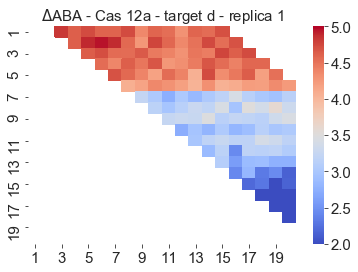

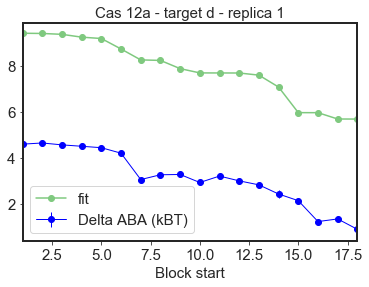

In [112]:
# epsC=np.array(Param_conc3[:21]).copy()
# epsC[1:] *= -1
# epsI=Param_conc3[21:41]
# epsI=[0]+epsI
# epsI=np.array(epsI)
# print(epsI)
# energy_block=[]
# for i in range(1,len(epsI)):
#     energy_block.append(np.log(sum(np.exp(epsC+epsI)))
#     epsI[i]=0
#plt.plot(range(0,21),np.cumsum(epsC),marker='o',label='Best Fit')
energy_block=[]
epsilon = Param_conc3[:-2]
for mmStart in range(1,21):
    block=np.arange(mmStart,21)
    energies=ABA.get_energies(epsilon,block, guide_length)
    energy_block.append(-np.log(np.sum(np.exp(-np.cumsum(energies)))))
print(len(energy_block))   

#plt.xlabel('Start mismatch block')

Path = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'
filename_3 = 'cas12a-target-d-replicate-1-delta-abas-processed.csv'
data_cas12a_d1 = pd.read_csv(Path+filename_3)
_, block_cas12a_d, block_start_cas12_d2 = plot_block_mm_ABA(data_cas12a_d1, data_name='Cas 12a - target d - replica 1', Canonical=True, Plot=True)
plt.plot(range(1,21),energy_block,marker='o',label='fit')
plt.legend()

# Compare parameters best fits delta and abs Cas12

In [44]:
matches2, mismatches2, rates2, landscape2, free_energy2, fast_Rloop2 = SAfits.process_SA_fits(['../Diewertje/19_5_2019_cas12_conc3/fit_19_5_2019_cas12_conc3_sim_18.txt'],44,'general_energies_no_kPR')


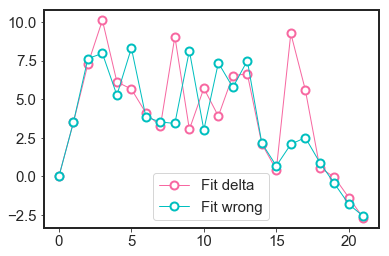

In [98]:
plt.plot(np.array(np.array(lowest_chi_squared)), color='#f768a1' , 
         marker='o', 
         lw=1,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='Fit delta');
plt.plot(np.array(landscape2)[0], color='c' , 
         marker='o', 
         lw=1,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='Fit wrong');
plt.legend()

In [99]:
Param_first=getParm.load_simm_anneal('../Diewertje/19_5_2019_cas12_conc3/fit_19_5_2019_cas12_conc3_sim_18.txt',Nparams)


In [100]:
np.array(Param_conc3)-np.array(Param_first)

array([-1.45940518,  0.3544455 , -2.50184879,  1.28466283,  3.51979591,
       -2.91441589,  0.53983653, -5.91008124, 10.72412637, -7.79176958,
        6.14878599, -4.21822158,  1.61985177, -0.805926  ,  0.19919239,
       -7.42647113,  4.08167121,  3.41848405, -0.72331567, -0.02898047,
        0.54037042, -0.4079705 ,  1.11010607, -0.04698345, -1.09387621,
       -0.10756461, -0.7153492 ,  0.37183469, -0.3283445 , -0.15523602,
       -0.317614  , -0.31279529, -0.09346637, -0.32900929, -0.23934361,
        3.05335092,  2.17556321, -3.0289376 ,  1.65638447,  0.3676262 ,
        0.82722618,  0.44406541,  0.02426342])

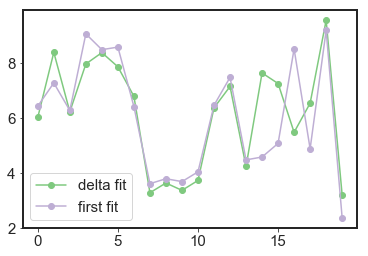

In [101]:
epsI=Param_conc3[21:41]
epsIfirst=Param_first[21:41]
plt.plot(range(len(epsI)),epsI,marker='o',label='delta fit')
plt.plot(range(len(epsI)),epsIfirst,marker='o',label='first fit')
plt.legend()

In [102]:
rates=10**np.array(Param_conc3[-2:])
rates_first=10**np.array(Param_first[-2:])
print(rates)
print(rates_first)

[3.31606605e-03 9.50518948e+02]
[1.19277291e-03 8.98870983e+02]


# Compare eye best fit and real best fit and wrong best fit

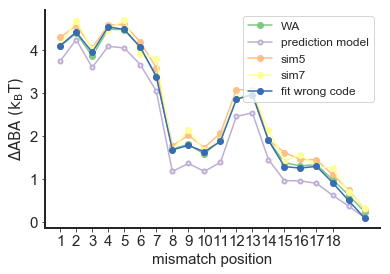

In [104]:
plt.plot(range(1,21),WAsingle_ordered[1:],marker='o',label='WA')
#_ = pltABA.predict_single_mm(param_play,model_id, T, guide_length, show_plot=True, show_data=True, data_file=rawABA)
_ = pltABA.predict_single_mm(Param_conc3,model_id, T, guide_length, show_plot=True, show_data=False, data_file=rawABA)
plot5 = pltABA.predict_single_mm(Param5,model_id, T, guide_length, show_plot=False, show_data=False, data_file=rawABA)
plot7 = pltABA.predict_single_mm(Param7,model_id, T, guide_length, show_plot=False, show_data=False, data_file=rawABA)
plotfirst = pltABA.predict_single_mm(Param_first,model_id, T, guide_length, show_plot=False, show_data=False, data_file=rawABA)
plt.plot(range(1,21),plot5,marker='o',label='sim5')
plt.plot(range(1,21),plot7,marker='o',label='sim7')
plt.plot(range(1,21),plotfirst,marker='o',label='fit wrong code')
plt.legend(prop={'size':12})

In [97]:
print('The chi-squared of the best fit is:',chi_squared[0])
print('The chi-squared of the 5th fit is:',chi_squared[4])
print('The chi-squared of the 7th fit is:',chi_squared[6])

The chi-squared of the best fit is: 48182.42562930001
The chi-squared of the 5th fit is: 49181.9900231
The chi-squared of the 7th fit is: 53263.8020015


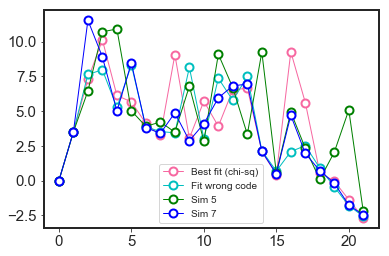

In [108]:
_,_,_,landscape5,_,_ = SAfits.process_SA_fits(['../Diewertje/19_5_2019_cas12_conc3/fit_19_5_2019_cas12_conc3_sim_5.txt'],44,'general_energies_no_kPR')
_,_,_,landscape7,_,_ = SAfits.process_SA_fits(['../Diewertje/19_5_2019_cas12_conc3/fit_19_5_2019_cas12_conc3_sim_7.txt'],44,'general_energies_no_kPR')

plt.plot(np.array(np.array(lowest_chi_squared)), color='#f768a1' , 
         marker='o', 
         lw=1,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='Best fit (chi-sq)');
plt.plot(np.array(landscape2)[0], color='c' , 
         marker='o', 
         lw=1,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='Fit wrong code');
plt.plot(np.array(landscape5)[0], color='g' , 
         marker='o', 
         lw=1,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='Sim 5');
plt.plot(np.array(landscape7)[0], color='b' , 
         marker='o', 
         lw=1,
         markersize =8,
         markerfacecolor='white',
         markeredgewidth= 2,
         label='Sim 7');
plt.legend(prop={'size':10})